In [2]:
import keras
keras.__version__

'2.4.3'

In [6]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [8]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [10]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [11]:
def build_generator():
    noise_shape = (100,)  # 1D array of size 100 (latent vector / noise)

    # Define your generator network
    # Here we are only using Dense layers. But network can be complicated based
    # on the application. For example, you can use VGG for super res. GAN.

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)  # Generated image

    return Model(noise, img)

In [15]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [16]:
def train(epochs, batch_size=128, save_interval=50):
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    # Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    # We then loop through a number of epochs to train our Discriminator by first selecting
    # a random batch of images from our true dataset, generating a set of images from our
    # Generator, feeding both set of images into our Discriminator, and finally setting the
    # loss parameters for both the real and fake images, as well as the combined loss.

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        # Research showed that separate training is more effective.
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        # take average loss from real and fake images.
        #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # And within the same loop we train our Generator, by setting the input noise and
        # ultimately training the Generator to have the Discriminator label its samples as valid
        # by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
        # Create noise vectors as input for generator.
        # Create as many noise vectors as defined by the batch size.
        # Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size)  # Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        # job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)

        # Additionally, in order for us to keep track of our training process, we print the
        # progress and save the sample image output depending on the epoch interval specified.
        # Plot the progress

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [17]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [18]:
optimizer = Adam(0.0002, 0.5)  # Learning rate and momentum.

In [19]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
__________________________________________________

2022-03-11 13:13:54.938740: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-11 13:13:54.940320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-11 13:13:55.010056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 13:13:55.010283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-03-11 13:13:55.010297: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-11 13:13:55.011518: I tensorflow/stream_executor/platform/defa

In [20]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)             

In [21]:
z = Input(shape=(100,))  # Our random input to the generator
img = generator(z)

In [22]:
discriminator.trainable = False

# This specifies that our Discriminator will take the images generated by our Generator
# and true dataset and set its output to a parameter called valid, which will indicate
# whether the input is real or not.
valid = discriminator(img)  # Validity check on the generated image

In [23]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

2022-03-11 13:14:59.345944: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-11 13:14:59.365007: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
2022-03-11 13:14:59.498334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


0 [D loss: 0.801618, acc.: 28.12%] [G loss: 0.923203]


FileNotFoundError: [Errno 2] No such file or directory: 'images/mnist_0.png'

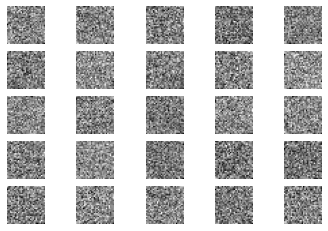

In [24]:
train(epochs=100, batch_size=32, save_interval=10)

In [5]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-03-11 17:23:39.257018: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-11 17:23:39.257779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-11 17:23:39.317212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 17:23:39.317524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-03-11 17:23:39.317545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-11 17:23:39.318635: I tensorflow/stream_executor/platform/defa